In [2]:
from datasets import load_from_disk
import torch
import tiktoken
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm.auto import tqdm

d:\projects\stage_gpt\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Dataset Download and Exploration

In [3]:
# Download and save dataset
"""
from datasets import load_dataset

ds = datasets.load_dataset("roneneldan/TinyStories")
ds.save_to_disk('datasets_local/tinystories')
"""

'\nfrom datasets import load_dataset\n\nds = datasets.load_dataset("roneneldan/TinyStories")\nds.save_to_disk(\'datasets_local/tinystories\')\n'

In [4]:
ds = load_from_disk("datasets_local/tinystories")

In [5]:
tokenizer = tiktoken.get_encoding('gpt2')

In [6]:
def print_sample(index, split='train', display=True, get_text=False):
    sample_text = ds[split][index]['text']
    encoded_sample = tokenizer.encode(ds['train'][0]['text'], allowed_special={'<|endoftext|>'})

    if display:
        print("=" * 45)
        print(f"Number of words: {len(sample_text.split(' '))}")
        print(f"Number of tokens: {len(encoded_sample)}")
        print("=" * 45)    
        print(sample_text)
        
    if get_text:
        return (sample_text, encoded_sample)
    else:
        return (None, None)

In [7]:
print_sample(45, split='validation')

Number of words: 135
Number of tokens: 162
Once upon a time, there was a family who loved to go camping. They had a big tent that they would put up in the woods. The mom and dad would work together to make sure the tent was set up just right. 

One day, they met a very nice man who was very generous. He gave them some food to eat and even helped them fix their tent when it got a hole in it. The family was very happy to have met such a kind man.

After they finished camping, the family went home and told all their friends about the generous man they met. They also talked about how they had to work hard to put up their tent, but it was worth it because they had so much fun camping. The end.


(None, None)

In [8]:
print_sample(124, split='train')

Number of words: 197
Number of tokens: 162
Once upon a time, there was a zipping sound in the quiet room. It sounded like someone was playing with something. Two friends, Mel and June, were curious and excited to find out what was making the noise. 

"What's that noise?" asked June.
"I don't know," said Mel, "Let's go find out!"

The two went searching around the room until they found the source of the noise: a pin, zipping up and down the wall!

"How unusual," said June, "How does it zip up and down the wall like that?

Mel put her finger to her lips and said, "Shhh, maybe it's magic?"

June's wide eyes lit up as she said, "That's it! I think we should try to figure out how it works!"

The two friends worked together to try and make the pin zip again. After a few minutes of hard work, the pin began to zip again!

"Woo-hoo!" cried Mel, "We did it! How exciting! I think this pin has a magical zipping power!"

June and Mel enjoyed their newfound discovery and magic pin. From that day for

(None, None)

# Deciding Model Parameters based on the Dataset

In [ ]:
# 47586
# Decide the model parameters

total_samples = len(ds['train']) + len(ds['validation'])
tokens = [0] * total_samples
curr_sample = 0
for split in ['train', 'validation']:
    for i in range(len(ds[split])):
        if curr_sample % 100000 == 0:
            print(curr_sample)
        tokens[curr_sample] = len(tokenizer.encode(ds[split][i]['text']))
        curr_sample += 1

100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000
1400000
1500000
1600000
1700000
1800000
1900000
2000000
2100000


IndexError: list assignment index out of range

Total Number of Tokens:  476616185
Mean Length: 222.5401233314143
Median:  191.0
Percentiles: [   0.  143.  158.  169.  180.  191.  205.  222.  252.  355. 1269.]


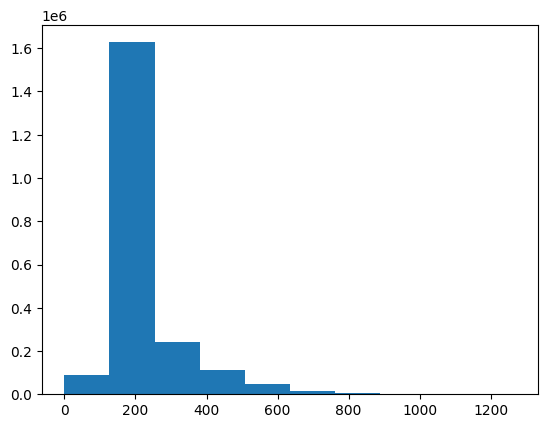

In [59]:
import matplotlib.pyplot as plt
import numpy as np

print("Total Number of Tokens: ", np.sum(tokens))
print("Mean Length:", np.mean(tokens))
print("Median: ", np.median(tokens))
print("Percentiles:", np.percentile(tokens, q = np.arange(0, 101, 10)))

_ = plt.hist(tokens)


Therefore, with context_length of 256, we have the whole story as the context for the next word prediction for >80% of the stories.
But, how many a parameters would that be? - It is 44.8M with this config - 

{'num_layers': 6,
  'num_heads': 8,
  'd_model': 512,
  'd_ff': 2048,
  'dropout_rate': 0.1,
  'context_length': 512,
  'vocab_size': 50257,
  'embedding_dim': 512},
 'context_length': 256

# Train Loop

In [9]:
import yaml
from transformer.transformer import GPTModel

with open("transformer/sample_config.yaml", "r") as f:
    config = yaml.safe_load(f)['config']

config.update({
    'context_length': 256,
    'd_model': 256,
    'embedding_dim': 256,
    'num_layers': 8,
    'num_heads': 4,
    'd_ff': 1024
})

print("Config:", config)

model = GPTModel(config)
print("#Params with the above config:", model.get_numel() / 1e6, "M parameters")

Config: {'num_layers': 8, 'num_heads': 4, 'd_model': 256, 'd_ff': 1024, 'dropout_rate': 0.1, 'context_length': 256, 'vocab_size': 50257, 'embedding_dim': 256}
#Params with the above config: 19.300177 M parameters


Out of this 19.3M parameters, 

- Token Embedding accounts for 50527 * 256 = 12.9M parameters. 
- The rest of the layers are 6.4M parameters.

This seems to be expected and explains the fixed cost of representation of words.

In [15]:
# Save the tokenized data into mmap
def process(sample):
    ids = tokenizer.encode_ordinary(sample['text'])
    return {'tokens': ids, 'len': len(ids)}

dataset_folder = "datasets_local/"
tokenized_ds = None
if not os.path.exists(os.path.join(dataset_folder, "train.bin")):
    tokenized_ds = ds.map(
        process,
        remove_columns=['text'],
        num_proc=8,
        desc="Tokenizing data"
    )

    for split, dset in tokenized_ds.items():
        total_len = np.sum(dset['len'])
        filename = os.path.join(dataset_folder, f"{split}.bin")
        fp = np.memmap(filename, dtype=np.uint16, mode = "w+", shape=(total_len,))
        batches = 1024

        idx = 0
        for i in tqdm(range(batches), desc="Saving to disk"):
            batch = dset.shard(num_shards=1024, index=i, contiguous=True).with_format('numpy')
            batch_arr = np.concatenate(batch['tokens'])
            fp[idx: idx + len(batch_arr)] = batch_arr
            idx += len(batch_arr)
            fp.flush() # Save each batch to reduce memory usage

In [16]:
device =  "cuda" if torch.cuda.is_available() else "cpu"
device_type = 'cuda' if 'cuda' in device else 'cpu' # for later use in torch.autocast
# note: float16 data type will automatically use a GradScaler

# How to use autocast https://wandb.ai/wandb_fc/tips/reports/How-To-Use-Autocast-in-PyTorch--VmlldzoyMTk4NTky
dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16' # 'float32', 'bfloat16', or 'float16', the latter will auto implement a GradScaler
ptdtype = {'float32': torch.float32, 'bfloat16': torch.bfloat16, 'float16': torch.float16}[dtype]

ctx = nullcontext() if device_type == 'cpu' else torch.amp.autocast(device_type=device_type, dtype=ptdtype)

In [17]:
def get_batch(context_size, batch_size, split='train', device='cpu'):
    data = np.memmap(os.path.join(dataset_folder, f"{split}.bin"), dtype=np.uint16, mode='r')
    ix = np.random.randint(low=0, high=len(data) - context_size - 1, size=batch_size)
    x = torch.vstack([torch.tensor(data[i:i+context_size]) for i in ix])
    y = torch.vstack([torch.tensor(data[i+1:i+1+context_size]) for i in ix])
    if device == 'cuda':
        x, y = x.pin_memory().to(device, non_blocking=True), y.pin_memory().to(device, non_blocking=True)
    return x.long(), y.long()

In [ ]:
def estimate_loss(model, eval_iters, context_size, batch_size=8, device='cpu'):
    out = {}
    model.eval()
    with torch.inference_mode():
        for split in ['train', 'validation']:
            losses = torch.zeros(eval_iters)
            for i in range(eval_iters):
                x, y = get_batch(context_size, batch_size, split=split, device=device)
                # with ctx:
                _, loss = model(x, y)
                losses[i] = loss.item()
            out[split] = losses.mean()
    model.train()
    return out

In [ ]:
log_freq = 100
max_iters = 1000
eval_iters = 100
gradient_accumulation_steps = 32
learning_rate = 1e-4
min_lr = 5e-5
warmup_iters = 1000
batch_size = 8

In [31]:
from torch.optim.lr_scheduler import LinearLR,SequentialLR, CosineAnnealingLR

In [32]:
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, betas=(0.9, 0.95), eps=1e-8, weight_decay=0.1)

scheduler_warmup = LinearLR(optimizer, total_iters=warmup_iters)
scheduler_decay = CosineAnnealingLR(optimizer, T_max=max_iters - warmup_iters, eta_min=min_lr)
scheduler = SequentialLR(optimizer, [scheduler_warmup, scheduler_decay], milestones=[warmup_iters])

In [33]:
best_val_loss = torch.inf
train_losses = []
val_losses = []
best_model_path = "best_slm_model.pt"

def train(model, optimizer, scheduler, config, device):
    best_val_loss = torch.inf
    context_size = config['context_length']
    for epoch in tqdm(range(max_iters), desc="Epochs"):
        if ((epoch + 1) % log_freq) == 0:
            curr_loss = estimate_loss(model, eval_iters, context_size, batch_size, device=device)
            train_losses.append(curr_loss['train'])
            val_losses.append(curr_loss['validation'])
            print(f"Epoch {epoch:3d} - Train Loss {curr_loss['train']:.4f}, Val Loss {curr_loss['validation']:.4f}")

            if curr_loss['validation'] < best_val_loss:
                best_val_loss = curr_loss['validation']
                torch.save(model.state_dict(), best_model_path)

        x, y = get_batch(context_size, batch_size, split='train', device=device)
        logits, loss = model(x, y)
        loss = loss / gradient_accumulation_steps
        loss.backward()

        if ((epoch + 1) % gradient_accumulation_steps == 0) or (epoch + 1 == max_iters):
            optimizer.step()
            optimizer.zero_grad()
            scheduler.step()


In [34]:
model = model.to(device)
train(model, optimizer, scheduler, config, device)

Epochs:  10%|▉         | 99/1000 [00:06<00:53, 16.92it/s]

Epoch  99 - Train Loss 147.1870, Val Loss 147.2832


Epochs:  20%|█▉        | 199/1000 [00:17<00:46, 17.17it/s]

Epoch 199 - Train Loss 138.1514, Val Loss 138.3302


Epochs:  30%|██▉       | 298/1000 [00:30<00:41, 16.74it/s]

Epoch 299 - Train Loss 127.6287, Val Loss 127.7110


Epochs:  40%|████      | 400/1000 [00:47<08:26,  1.18it/s]

Epoch 399 - Train Loss 115.9785, Val Loss 116.0830


Epochs:  50%|████▉     | 499/1000 [00:53<00:29, 16.73it/s]

Epoch 499 - Train Loss 104.0334, Val Loss 104.1917


Epochs:  60%|█████▉    | 599/1000 [01:04<00:24, 16.06it/s]

Epoch 599 - Train Loss 92.6496, Val Loss 92.8690


Epochs:  70%|██████▉   | 699/1000 [01:15<00:18, 16.40it/s]

Epoch 699 - Train Loss 82.6958, Val Loss 82.6086


Epochs:  80%|███████▉  | 799/1000 [01:27<00:12, 16.08it/s]

Epoch 799 - Train Loss 74.3929, Val Loss 74.4179


Epochs:  90%|████████▉ | 898/1000 [01:38<00:06, 16.61it/s]

Epoch 899 - Train Loss 66.5160, Val Loss 66.5801


Epochs: 100%|█████████▉| 998/1000 [01:49<00:00, 16.61it/s]

Epoch 999 - Train Loss 62.3631, Val Loss 62.4472


Epochs: 100%|██████████| 1000/1000 [01:54<00:00,  8.70it/s]


In [16]:
#Load the model
model = GPTModel(config)  # re-create the model with same config
best_model_params_path = "best_slm_model.pt"
model.load_state_dict(torch.load(best_model_params_path, map_location=torch.device(device))) # load best model states

<All keys matched successfully>

In [35]:
sentence = "Once upon a time there was a pumpkin."
context = (torch.tensor(tokenizer.encode_ordinary(sentence)).unsqueeze(dim = 0)).to(device)
y = model.generate(context, 16)
print(tokenizer.decode(y.squeeze().tolist()))

Once upon a time there was a pumpkin.lorelorelorelorelorelorelorelorelorelorelorelorelorelorelorelore
